In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [14]:
from pennylane import numpy as np 
import pennylane as qml
from matplotlib import pyplot as plt

In [3]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(weights, f=None):
    qml.QAOAEmbedding(features=f, weights=weights, wires=range(2))
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def circuit2(weights, features):
    qml.QAOAEmbedding(features=features, weights=weights, wires=range(2))
    return qml.expval(qml.PauliZ(0))


shape = qml.QAOAEmbedding.shape(n_layers=2, n_wires=2)
weights = np.random.random(shape, requires_grad=True)
features = np.random.random(2, requires_grad=True)
opt = qml.GradientDescentOptimizer()
for i in range(10):
    weights, features = opt.step(circuit2, weights, features)
    print("Step ", i, "\n weights = ", weights, "\n features = ", features,"\n")

Step  0 
 weights =  [[0.69013709 0.07817787 0.31087897]
 [0.4799149  0.33420057 0.41711107]] 
 features =  [0.9396561  0.09648909] 

Step  1 
 weights =  [[0.68410231 0.07551112 0.31126843]
 [0.47389437 0.33851052 0.41711107]] 
 features =  [0.94293599 0.09628491] 

Step  2 
 weights =  [[0.67812324 0.07284245 0.31164787]
 [0.46792636 0.34274555 0.41711107]] 
 features =  [0.946043  0.0960746] 

Step  3 
 weights =  [[0.67220156 0.07017453 0.31201729]
 [0.46201265 0.34690716 0.41711107]] 
 features =  [0.9489876  0.09585837] 

Step  4 
 weights =  [[0.66633881 0.06750984 0.31237671]
 [0.45615487 0.35099678 0.41711107]] 
 features =  [0.95177966 0.09563643] 

Step  5 
 weights =  [[0.66053635 0.06485072 0.31272618]
 [0.45035452 0.35501582 0.41711107]] 
 features =  [0.95442854 0.09540898] 

Step  6 
 weights =  [[0.65479542 0.06219934 0.31306574]
 [0.44461295 0.3589656  0.41711107]] 
 features =  [0.95694307 0.09517627] 

Step  7 
 weights =  [[0.64911711 0.05955771 0.31339549]
 [0.438

In [11]:
from classifiers.quantum.qml.qasvm import PseudoTensorSoftQASVM
from classifiers.datasets.sklearn import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap

ds = SklearnDataset('iris', (-np.pi, np.pi), 0)
data, label, testdata, testlabel = ds.sample_training_and_test_dataset((128, 22), return_X_y=True)

device = qml.device('lightning.qubit', wires=int(np.log2(len(label))))
feature_map = MultilayerCircuit9FeatureMap(4)
def var_form(params):
    qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)

parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=10, n_wires=len(device.wires))
qasvm = PseudoTensorSoftQASVM(data, label, device, feature_map=feature_map, var_form=var_form)


In [5]:
params = np.random.random(parameter_shape, requires_grad=True)
opt = qml.AdamOptimizer()
cost_list = []
for i in range(1000):
    params, cost = opt.step_and_cost(qasvm.cost_fn, params)
    cost_list.append(cost)

KeyboardInterrupt: 

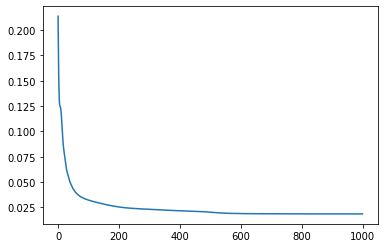

In [32]:
plt.plot(cost_list)

In [34]:
data, label, testdata, testlabel = ds.sample_training_and_test_dataset((128, 22), return_X_y=True)

In [38]:
fvec = qasvm.f(ds.data, params)
esty = np.where(fvec>0, 1, 0)
accuarcy = sum(esty==ds.target)/len(ds.target)
print(accuarcy)

0.9933333333333333


In [13]:
from classifiers.quantum.qml.ansatz import PQC_Properties
device = qml.device('lightning.qubit', wires=10)
def var_form(params):
    qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)

parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=15, n_wires=len(device.wires))
prop = PQC_Properties(pqc=var_form, param_shape=parameter_shape, device=device)
prop.expressibility()

1.0044999933817374e-06

In [16]:
def express(n_layer):
    device = qml.device('lightning.qubit', wires=10)
    def var_form(params):
        qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)
    parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=n_layer, n_wires=len(device.wires))
    prop = PQC_Properties(pqc=var_form, param_shape=parameter_shape, device=device)
    return prop.expressibility(num_samples=2**13)

layers = list(range(15))
expr = list(map(express, layers))

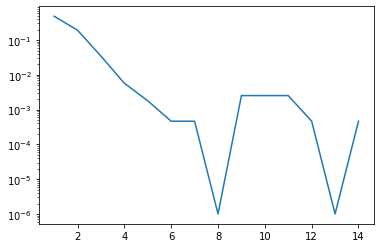

In [17]:
plt.plot(layers, expr)
plt.yscale('log')

In [19]:
def express(n_wires):
    device = qml.device('lightning.qubit', wires=n_wires)
    def var_form(params):
        qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)
    parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=10, n_wires=len(device.wires))
    prop = PQC_Properties(pqc=var_form, param_shape=parameter_shape, device=device)
    return prop.expressibility(num_samples=2**13)

layers = list(range(1, 15))
expr = list(map(express, layers))

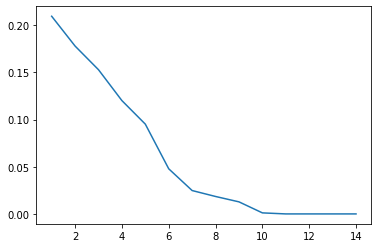

In [21]:
plt.plot(layers, expr)

In [2]:
import pennylane as qml
from pennylane import numpy as np 
from classifiers.quantum.qml.qasvm import PseudoTensorSoftQASVM
from classifiers.datasets.sklearn import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pca = PCA(n_components=10)


In [5]:
data = mnist.data.to_numpy()
label = mnist.target.to_numpy().astype(float)
mask = (label==0) + (label==1)
data = data[mask]
label = label[mask]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, label, train_size=2**13, test_size=2**10)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pca.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

In [8]:
for i, d in enumerate(X_train):
    X_train[i] = d/np.linalg.norm(d)
for i, d in enumerate(X_test):
    X_test[i] = d/np.linalg.norm(d)
train_kernel = np.matmul(X_train, X_train.T)
test_kernel = np.matmul(X_train, X_test.T)

In [9]:
from qiskit.circuit.library import ZZFeatureMap
device = qml.device('lightning.qubit', wires=int(np.log2(len(y_train))))
feature_map = ZZFeatureMap(feature_dimension=10, reps=3, entanglement='linear')
def var_form(params):
    qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)

parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=10, n_wires=len(device.wires))
qasvm = PseudoTensorSoftQASVM(data=X_train, label=y_train, device=device, feature_map=feature_map, var_form=var_form)
kernel = qasvm.kernel_matrix
kernel2 = qasvm._qk.evaluate(X_train, X_test)

In [10]:
def var_form(params):
    qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)

parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=15, n_wires=len(device.wires))
qasvm = PseudoTensorSoftQASVM(data=kernel, label=y_train, device=device, feature_map=None, var_form=var_form, C=10**3, lamda=10**3)

In [11]:
from tqdm import tqdm, trange
params = np.random.random(parameter_shape, requires_grad=True)
opt = qml.AdamOptimizer()
cost_list = []
for i in trange(2**10):
    params, cost = opt.step_and_cost(qasvm.cost_fn, params)
    cost_list.append(cost)

100%|██████████| 1024/1024 [1:25:21<00:00,  5.00s/it]


In [12]:
from sklearn.metrics import accuracy_score
qasvm.accuracy(kernel2, y_test, params)

0.9541015625

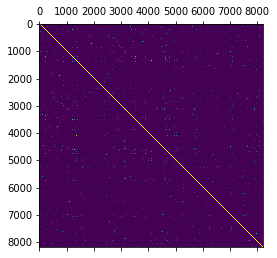

In [58]:
plt.matshow(kernel)

In [51]:
from sklearn.svm import SVC 
svm = SVC(kernel='precomputed', C=10**4)
svm.fit(kernel, y_train)

SVC(C=10000, kernel='precomputed')

In [52]:
accuracy_score(svm.predict(kernel2.T), y_test)

0.953125

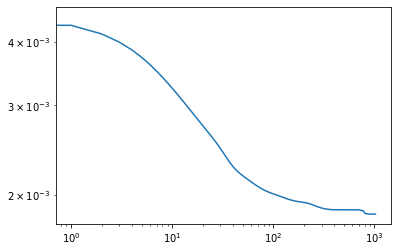

In [15]:
plt.plot(cost_list)
plt.xscale('log')
plt.yscale('log')

In [54]:
from classifiers.convex.svm import CvxSoftQASVM

cvxsvm = CvxSoftQASVM(kernel='precomputed', C=qasvm.C, lamda=qasvm.lamda)
cvxsvm.fit(kernel, y_train)
cvxsvm.accuracy(kernel2.T, y_test)

0.953125

In [18]:
from pandas import DataFrame

df = DataFrame({10:{100:1, 200:2}, 20:{100:3, 200:4}})
df

,10,20
100,1,3
200,2,4


In [20]:
df.columns.to_numpy()

array([10, 20])

In [21]:
df.index.to_numpy()

array([100, 200])

In [30]:
import numpy as np
n_qubits_list = np.arange(6, 13+1, dtype=int) # 6 7 8 9 10 11 12 13
n_layers_list = np.arange(1, 15+1, 2, dtype=int) # 1 3 5 7 9 11 13 15
df = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list})

In [59]:
df[7][15]=30

In [60]:
df

,6,7,8,9,10,11,12,13
1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0
15,1,30,0,0,0,0,0,0


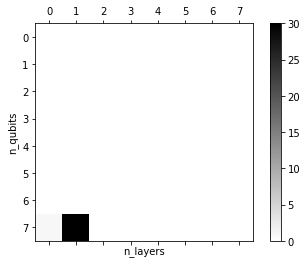

In [65]:
fig, ax = plt.subplots()
mappable = ax.matshow(df, cmap='binary')
ax.set_xlabel('n_layers')
ax.set_ylabel('n_qubits')
fig.colorbar(mappable)

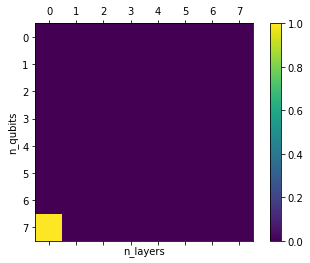

In [56]:
fig

In [66]:
import sys
from pathlib import Path
import json

import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.providers.aer import StatevectorSimulator
from qiskit.circuit.library import ZZFeatureMap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from pandas import DataFrame

sys.path.extend(['/home/quic/QUIC-Projects/'])
from classifiers.quantum.qml.qasvm import PseudoTensorSoftQASVM
from classifiers.datasets.sklearn import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap
from classifiers.convex.svm import CvxSoftQASVM


def load_train_and_test_data(dataset, train_size:float=2**13, test_size:float=2**7, random_state:int=None):
    data = dataset.data.to_numpy()
    label = dataset.target.to_numpy().astype(float)
    mask = (label==0) + (label==1)
    data = data[mask]
    label = label[mask]
    X_train, X_test, y_train, y_test = train_test_split(data, label, train_size=train_size, test_size=test_size, random_state=random_state)
    return X_train, y_train, X_test, y_test

def reduce_and_normalize_data(n_components, X_train, X_test):
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
    X_train = scaler.fit_transform(X_train)
    X_train = pca.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_test = pca.transform(X_test)
    for i, d in enumerate(X_train):
        X_train[i] = d/np.linalg.norm(d)
    for i, d in enumerate(X_test):
        X_test[i] = d/np.linalg.norm(d)
    return X_train, X_test

def construct_training_and_test_quantum_kernel_matrix(feature_map:QuantumCircuit, X_train:np.ndarray, X_test:np.ndarray):
    quantum_instance = QuantumInstance(backend = StatevectorSimulator())
    quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance, enforce_psd=False)
    training_kernel = quantum_kernel.evaluate(X_train, X_train)
    test_kernel = quantum_kernel.evaluate(X_train, X_test)
    return training_kernel, test_kernel

def train_model(qasvm:PseudoTensorSoftQASVM, initial_params:np.ndarray, steps:int=2**10, writer:SummaryWriter=None, stepsize:float=0.01):
    params = initial_params
    opt = qml.AdamOptimizer(stepsize=stepsize)
    cost_list = []
    for step in range(1, steps+1):
        params, cost = opt.step_and_cost(qasvm.cost_fn, params)
        cost_list.append(cost.item())
        if writer is not None:
            writer.add_scalar('Training/Cost', cost.item(), step)
    return params, np.array(cost_list)

def test_model(qasvm:PseudoTensorSoftQASVM, params:np.ndarray, test_kernel:np.ndarray, y_test):
    cost = qasvm.cost_fn(params).item()
    fvec = qasvm.f(test_kernel, params).numpy()
    esty = np.where(fvec>0, 1, 0)
    accuracy = accuracy_score(esty, y_test)
    return fvec, accuracy, cost

def train_and_test_reference(cvxsvm:CvxSoftQASVM, train_kernel:np.ndarray, test_kernel:np.ndarray, y_train:np.ndarray, y_test:np.ndarray):
    cvxsvm.fit(train_kernel, y_train)
    fvec = cvxsvm.f(test_kernel.T)
    accuarcy = cvxsvm.accuracy(test_kernel.T, y_test)
    cost = cvxsvm.dual_objective_value
    return fvec, accuarcy, cost

def epsilon(fvec, true_fvec):
    return np.sqrt(np.mean(np.abs(fvec-true_fvec)**2)).item()

def make_figure(df:DataFrame):
    fig, ax = plt.subplots()
    mappable = ax.matshow(df, cmap='binary')
    ax.set_xlabel('n_layers')
    ax.set_ylabel('n_qubits')
    fig.colorbar(mappable)
    plt.show()
    return fig

def main():
    # setting
    dir_path = Path.cwd() / 'numerical_simulation'
    dir_path.mkdir(parents=True, exist_ok=True)
    dataset = fetch_openml('mnist_784')
    print('loaded mnist data set')
    test_size = 2**3
    n_steps = 2**3
    stepsize = 0.001
    n_feature = 4
    n_qubits_list = np.arange(6, 13+1, dtype=int) # 6 7 8 9 10 11 12 13
    n_layers_list = np.arange(1, 15+1, 2, dtype=int) # 1 3 5 7 9 11 13 15
    C=10**3
    lamda=10**3
    summary_writer = SummaryWriter(log_dir=dir_path)

    epsilon_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list})
    delta_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list})

    for n_qubits in n_qubits_list:
        sub_dir_path = dir_path / f'n_qubits={n_qubits}'
        sub_dir_path.mkdir(parents=True, exist_ok=True)
        # data loading
        train_size = 2**n_qubits
        print(train_size)
        X_train, y_train, X_test, y_test = load_train_and_test_data(dataset, train_size=train_size, test_size=test_size, random_state=90348)
        X_train, X_test = reduce_and_normalize_data(n_feature, X_train, X_test)
        feature_map = ZZFeatureMap(feature_dimension=n_feature, reps=3, entanglement='linear')
        train_kernel, test_kernel = construct_training_and_test_quantum_kernel_matrix(feature_map=feature_map, X_train=X_train, X_test=X_test)
        print('kernel matrix generated')

        # set reference
        cvxsvm = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
        true_fvec, true_accuarcy, true_cost = train_and_test_reference(cvxsvm, train_kernel, test_kernel, y_train, y_test)

        # save data and reference
        np.save(sub_dir_path/'X_train.npy', X_train)
        np.save(sub_dir_path/'X_test.npy', X_test)
        np.save(sub_dir_path/'y_train.npy', y_train)
        np.save(sub_dir_path/'y_test.npy', y_test)
        np.save(sub_dir_path/'train_kernel.npy', train_kernel)
        np.save(sub_dir_path/'test_kernel.npy', test_kernel)
        with open(sub_dir_path/'reference.json', 'w') as fp:
            json.dump(dict(
                accuracy=true_accuarcy, last_cost = true_cost, fvec=true_fvec
            ), fp=fp, default=list)

        # ansatz setup
        device:qml.Device = qml.device('lightning.qubit', wires=n_qubits)
        def var_form(params):
            qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)
        for n_layers in n_layers_list:
            sub_sub_dir_path = sub_dir_path / f'n_layers={n_layers}'
            sub_sub_dir_path.mkdir(parents=True, exist_ok=True)
            writer = SummaryWriter(log_dir=sub_sub_dir_path)
            # training
            parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=device.num_wires)
            qasvm = PseudoTensorSoftQASVM(data=train_kernel, label=y_train, C=C, lamda=lamda, device=device, feature_map=None, var_form=var_form)
            params=qml.numpy.random.random(parameter_shape, requires_grad=True)
            opt = qml.AdamOptimizer(stepsize=stepsize)
            cost_list = []
            for step in range(1, n_steps+1):
                params, cost = opt.step_and_cost(qasvm.cost_fn, params)
                cost_list.append(cost.item())
                if writer is not None:
                    writer.add_scalar('Training/Cost', cost_list[-1], step)
                    writer.add_scalar('Training/Normal_Cost', (cost_list[-1]-true_cost)/(cost_list[0]-true_cost), step)
            # test
            cost = qasvm.cost_fn(params.numpy()).item()
            fvec = qasvm.f(test_kernel, params.numpy()).numpy()
            accuracy = accuracy_score(np.where(fvec>0, 1, 0), y_test)
            epsilon_summary[n_qubits][n_layers] = epsilon(fvec, true_fvec)
            delta_summary[n_qubits][n_layers] = cost-true_cost
            summary_writer.add_figure('Test/epsilon', make_figure(epsilon_summary))
            summary_writer.add_figure('Test/delta', make_figure(delta_summary))
            # save result
            with open(sub_sub_dir_path/'result.json', 'w') as fp:
                json.dump(dict(
                    accuracy=accuracy, last_cost = cost, fvec=fvec, cost_list=cost_list
                ), fp=fp, default=list)



loaded mnist data set
64
kernel matrix generated


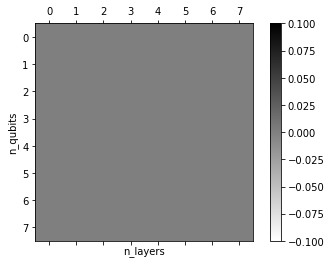

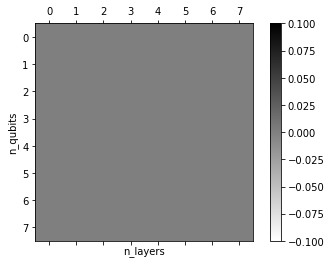

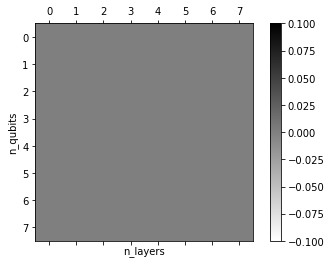

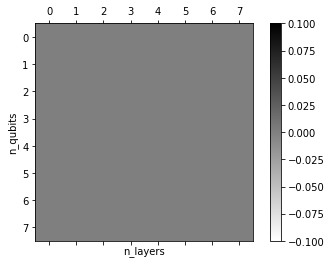

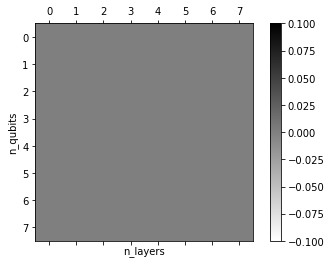

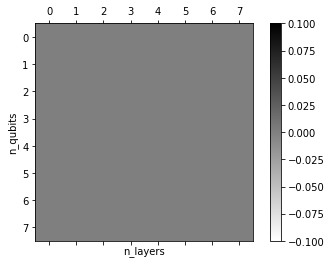

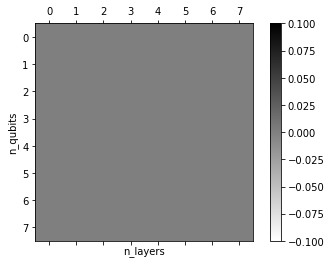

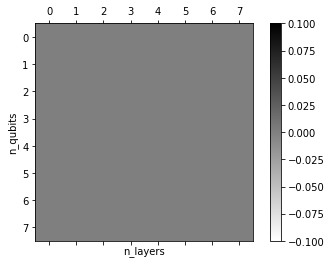

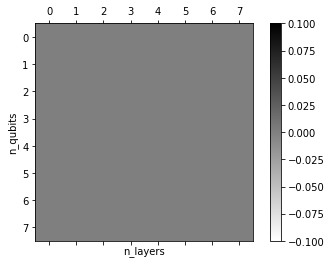

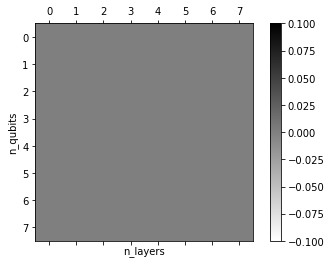

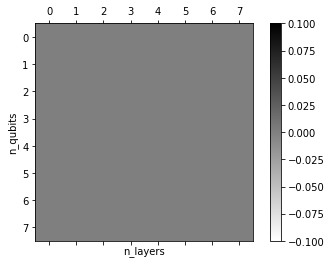

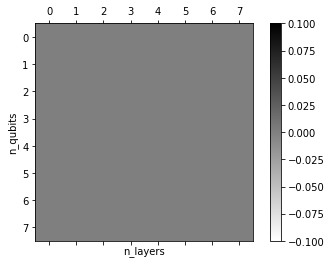

KeyboardInterrupt: 

In [69]:
dir_path = Path.cwd() / 'numerical_simulation'
dir_path.mkdir(parents=True, exist_ok=True)
dataset = fetch_openml('mnist_784')
print('loaded mnist data set')


In [71]:
test_size = 2**3
n_steps = 2**3
stepsize = 0.001
n_feature = 4
n_qubits_list = np.arange(6, 13+1, dtype=int) # 6 7 8 9 10 11 12 13
n_layers_list = np.arange(1, 15+1, 2, dtype=int) # 1 3 5 7 9 11 13 15
C=10**3
lamda=10**3
summary_writer = SummaryWriter(log_dir=dir_path)

epsilon_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)
delta_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)

for n_qubits in n_qubits_list:
    sub_dir_path = dir_path / f'n_qubits={n_qubits}'
    sub_dir_path.mkdir(parents=True, exist_ok=True)
    # data loading
    train_size = 2**n_qubits
    print(train_size)
    X_train, y_train, X_test, y_test = load_train_and_test_data(dataset, train_size=train_size, test_size=test_size, random_state=90348)
    X_train, X_test = reduce_and_normalize_data(n_feature, X_train, X_test)
    feature_map = ZZFeatureMap(feature_dimension=n_feature, reps=3, entanglement='linear')
    train_kernel, test_kernel = construct_training_and_test_quantum_kernel_matrix(feature_map=feature_map, X_train=X_train, X_test=X_test)
    print('kernel matrix generated')

    # set reference
    cvxsvm = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
    true_fvec, true_accuarcy, true_cost = train_and_test_reference(cvxsvm, train_kernel, test_kernel, y_train, y_test)

    # save data and reference
    np.save(sub_dir_path/'X_train.npy', X_train)
    np.save(sub_dir_path/'X_test.npy', X_test)
    np.save(sub_dir_path/'y_train.npy', y_train)
    np.save(sub_dir_path/'y_test.npy', y_test)
    np.save(sub_dir_path/'train_kernel.npy', train_kernel)
    np.save(sub_dir_path/'test_kernel.npy', test_kernel)
    with open(sub_dir_path/'reference.json', 'w') as fp:
        json.dump(dict(
            accuracy=true_accuarcy, last_cost = true_cost, fvec=true_fvec
        ), fp=fp, default=list)

    # ansatz setup
    device:qml.Device = qml.device('lightning.qubit', wires=n_qubits)
    def var_form(params):
        qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)
    for n_layers in n_layers_list:
        sub_sub_dir_path = sub_dir_path / f'n_layers={n_layers}'
        sub_sub_dir_path.mkdir(parents=True, exist_ok=True)
        writer = SummaryWriter(log_dir=sub_sub_dir_path)
        # training
        parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=device.num_wires)
        qasvm = PseudoTensorSoftQASVM(data=train_kernel, label=y_train, C=C, lamda=lamda, device=device, feature_map=None, var_form=var_form)
        params=qml.numpy.random.random(parameter_shape, requires_grad=True)
        opt = qml.AdamOptimizer(stepsize=stepsize)
        cost_list = []
        for step in range(1, n_steps+1):
            params, cost = opt.step_and_cost(qasvm.cost_fn, params)
            cost_list.append(cost.item())
            if writer is not None:
                writer.add_scalar('Training/Cost', cost_list[-1], step)
                writer.add_scalar('Training/Normal_Cost', (cost_list[-1]-true_cost)/(cost_list[0]-true_cost), step)
        # test
        cost = qasvm.cost_fn(params.numpy()).item()
        fvec = qasvm.f(test_kernel, params.numpy()).numpy()
        accuracy = accuracy_score(np.where(fvec>0, 1, 0), y_test)
        epsilon_summary[n_qubits][n_layers] = epsilon(fvec, true_fvec)
        delta_summary[n_qubits][n_layers] = cost-true_cost
        #summary_writer.add_figure('Test/epsilon', make_figure(epsilon_summary))
        #summary_writer.add_figure('Test/delta', make_figure(delta_summary))
        print(epsilon_summary)
        # save result
        with open(sub_sub_dir_path/'result.json', 'w') as fp:
            json.dump(dict(
                accuracy=accuracy, last_cost = cost, fvec=fvec, cost_list=cost_list
            ), fp=fp, default=list)

64
kernel matrix generated
    6   7   8   9   10  11  12  13
1    0   0   0   0   0   0   0   0
3    0   0   0   0   0   0   0   0
5    0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   0   0
9    0   0   0   0   0   0   0   0
11   0   0   0   0   0   0   0   0
13   0   0   0   0   0   0   0   0
15   0   0   0   0   0   0   0   0
    6   7   8   9   10  11  12  13
1    0   0   0   0   0   0   0   0
3    0   0   0   0   0   0   0   0
5    0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   0   0
9    0   0   0   0   0   0   0   0
11   0   0   0   0   0   0   0   0
13   0   0   0   0   0   0   0   0
15   0   0   0   0   0   0   0   0
    6   7   8   9   10  11  12  13
1    0   0   0   0   0   0   0   0
3    0   0   0   0   0   0   0   0
5    0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   0   0
9    0   0   0   0   0   0   0   0
11   0   0   0   0   0   0   0   0
13   0   0   0   0   0   0   0   0
15   0   0   0   0   0   0   0   0
    6   7   8   9   10  11  

KeyboardInterrupt: 

In [83]:
epsilon_summary[n_qubits][n_layers] = epsilon(fvec, true_fvec)
epsilon_summary

,6,7,8,9,10,11,12,13
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.040749,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
epsilon_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)
delta_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)

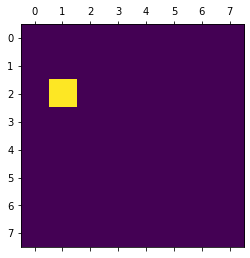

In [84]:
plt.matshow(epsilon_summary)

In [81]:
epsilon_summary.dtypes

6     int64
7     int64
8     int64
9     int64
10    int64
11    int64
12    int64
13    int64
dtype: object